## Plant Seedling Image classification with Convolutional Neural Networks

####Kaggle Data Set "Plant Seedlings Classification"
https://www.kaggle.com/c/plant-seedlings-classification


In [1]:
## Check GPU memory availability

!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Running setup.py bdist_wheel for gputil ... - done
  Stored in directory: /root/.cache/pip/wheels/17/0f/04/b79c006972335e35472c0b835ed52bfc0815258d409f560108
Successfully built gputil
  Running setup.py bdist_wheel for humanize ... - done
  Stored in directory: /root/.cache/pip/wheels/69/86/6c/f8b8593bc273ec4b0c653d3827f7482bb2001a2781a73b7f44
Successfully built humanize
Gen RAM Free: 13.0 GB  | Proc size: 137.0 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [2]:
## install and setup Fast.ai v.0.7.0, pytorch and dependencies

#!pip uninstall fastai
!pip install Pillow==4.1.1
!pip install "fastai==0.7.0"
!pip install torchtext==0.2.3
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
!apt update && apt install -y libsm6 libxext6

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch
!pip install image

%matplotlib inline
from fastai.imports import *


    100% |████████████████████████████████| 5.7MB 7.5MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 122kB 3.7MB/s 
    100% |████████████████████████████████| 112kB 7.1MB/s 
    100% |████████████████████████████████| 71kB 25.5MB/s 
    100% |████████████████████████████████| 61kB 26.2MB/s 
    100% |████████████████████████████████| 496.4MB 32kB/s 
    100% |████████████████████████████████| 184kB 9.8MB/s 
    100% |████████████████████████████████| 122kB 29.7MB/s 
    100% |████████████████████████████████| 2.2MB 4.9MB/s 
    100% |████████████████████████████████| 1.5MB 8.1MB/s 
    100% |████████████████████████████████| 3.6MB 4.4MB/s 
    100% |████████████████████████████████| 92kB 29.0MB/s 
    100% |████████████████████████████████| 11.6MB 3.1MB/s 
    100% |████████████████████████████████| 112kB 30.7MB/s 
    100% |████████████████████████████████| 61kB 21

In [3]:
import sys
sys.version

'3.6.6 (default, Sep 12 2018, 18:26:19) \n[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]'

In [4]:
import torch
print(torch.__version__)

0.3.0.post4


It's important that you have a working NVidia GPU set up. The programming framework used to behind the scenes to work with NVidia GPUs is called CUDA. Therefore, you need to ensure the following line returns `True` before you proceed. If you have problems with this, please check the FAQ and ask for help on [the forums](http://forums.fast.ai).

In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
torch.cuda.is_available()

True

In addition, NVidia provides special accelerated functions for deep learning in a package called CuDNN. Although not strictly necessary, it will improve training performance significantly, and is included by default in all supported fastai configurations. Therefore, if the following does not return `True`, you may want to look into why.

In [7]:
torch.backends.cudnn.enabled

True

In [0]:
import fastai as fai

In [0]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [0]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Loading Plant Seedling Data from Google Drive

In [0]:
# Install the Kaggle API
#!pip3 install kaggle
#more info at 
# https://github.com/corykendrick/fastai_in_colab/blob/master/Using_Google_Colab_for_Fastai.ipynb
# https://forums.fast.ai/t/fast-ai-with-google-colab/18882/14  

# instead I've manually uploaded kaggle Plant Seedling Dataset to google drive

The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, has recently released a dataset containing images of approximately 960 unique plants belonging to 12 species at several growth stages.
* Black-grass
* Charlock
* Cleavers
* Common Chickweed
* Common wheat
* Fat Hen
* Loose Silky-bent
* Maize
* Scentless Mayweed
* Shepherds Purse
* Small-flowered Cranesbill
* Sugar beet



Here we import the libraries we need. We'll learn about what each does during the course.

In [12]:
!pip install PyDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

    100% |████████████████████████████████| 993kB 10.9MB/s 
  Running setup.py bdist_wheel for PyDrive ... - done
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
PATH = "drive/My Drive/data/PlantSeedlings/"

In [0]:
import pandas as pd
import numpy as np

## First look at pictures

Our library will assume that you have *train* and *valid* directories. It also assumes that each dir will have subdirs for each class you wish to recognize

In [16]:
os.listdir(PATH)

['models',
 'tmp',
 'valid',
 'sample_submission (copy).csv',
 'Plant Seedlings Classification | Kaggle.desktop',
 'sample_submission.csv',
 'train',
 'test']

In [17]:
files = os.listdir(f'{PATH}train/Maize')[:5]
files

['a6e44df4f.png',
 '006196e1c.png',
 'c05a8d7e1.png',
 'b8b2658d9.png',
 '8d2004e7a.png']

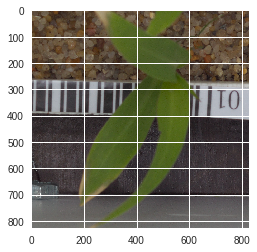

In [18]:
img = plt.imread(f'{PATH}train/Maize/{files[0]}')
plt.imshow(img);

Here is how the raw data looks like

In [19]:
img.shape

(826, 826, 3)

In [20]:
img[:4,:4]

array([[[0.43922, 0.36863, 0.27059],
        [0.41961, 0.35686, 0.2549 ],
        [0.39608, 0.33725, 0.23137],
        [0.40392, 0.34118, 0.23529]],

       [[0.42353, 0.3451 , 0.24314],
        [0.41569, 0.34902, 0.24706],
        [0.41961, 0.36078, 0.25882],
        [0.41176, 0.35686, 0.2549 ]],

       [[0.40784, 0.32941, 0.22353],
        [0.41176, 0.3451 , 0.24314],
        [0.40392, 0.34902, 0.24314],
        [0.4    , 0.3451 , 0.24314]],

       [[0.41569, 0.3451 , 0.23529],
        [0.40784, 0.3451 , 0.23922],
        [0.4    , 0.3451 , 0.23922],
        [0.39608, 0.3451 , 0.24314]]], dtype=float32)

In [21]:
# list list of classes by parsing train direcotry

from subprocess import check_output
classes = check_output(["ls", f'{PATH}train']).decode("utf8").strip().split("\n")
classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [22]:
# again, list total number of classes, and list them all
# os.list dir sorting depends on OS dependent file indexing, so leaving it as it is

classes = os.listdir(f'{PATH}/train')
classes.sort()
print("Class Total Count: ", len(classes))
print(classes)

Class Total Count:  12
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [23]:
# parse all classes and assemble python list object []
# each list element will contain array of files names of a class

all_images_class = [os.listdir(f'{PATH}/train/'+c) for c in classes]
#int_to_classes = {i:classes[i] for i in range(len(classes))}
#classes_to_int = {classes[i]:i for i in range(len(classes))}
print("Classes: ",len(all_images_class) )

Classes:  12


In [24]:
# create python data dictionary {}, with key="text", and value as length(of size) of containing list object array (1D)
# gives histogram like file count for each class

dataDict= {"n_images": [len(x) for x in all_images_class]}
print("file count in each class: ",dataDict)
trainFiles = 0
for x in all_images_class:
  trainFiles = trainFiles+len(x)
print(" Total Train Files: ", trainFiles)

file count in each class:  {'n_images': [211, 313, 230, 489, 177, 380, 524, 177, 413, 185, 397, 308]}
 Total Train Files:  3804


In [25]:
# list object for validation images too

valid_classes = os.listdir(f'{PATH}/valid')
valid_classes.sort()
print(valid_classes)
all_valid_img_class = [os.listdir(f'{PATH}/valid/'+c) for c in valid_classes]
ValDataDict= {"m_images": [len(x) for x in all_valid_img_class]}
print("file count in each validation class: ",ValDataDict)
validFiles = 0
for x in all_valid_img_class:
  validFiles = validFiles+len(x)
print(" Total Valid Files: ", validFiles)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
file count in each validation class:  {'m_images': [52, 78, 57, 122, 44, 95, 130, 44, 103, 46, 99, 77]}
 Total Valid Files:  947


In [26]:
# assemble panda Dataframe {class pandas.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)}
# Train Data set

df = pd.DataFrame(dataDict, index=classes)
df.index.name = "Seedlings"
df

,n_images
Seedlings,
Black-grass,211
Charlock,313
Cleavers,230
Common Chickweed,489
Common wheat,177
Fat Hen,380
Loose Silky-bent,524
Maize,177
Scentless Mayweed,413


In [27]:
# assemble panda Dataframe [class pandas.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)]
# Valid Data set 0.25%

df2 = pd.DataFrame(ValDataDict, index=classes)
df2.index.name = "Seedlings"
df2

,m_images
Seedlings,
Black-grass,52
Charlock,78
Cleavers,57
Common Chickweed,122
Common wheat,44
Fat Hen,95
Loose Silky-bent,130
Maize,44
Scentless Mayweed,103


In [28]:
# apeend two data frames
full_df = pd.concat([df, df2], axis=1)
full_df.sort_values('n_images',ascending=False)

,n_images,m_images
Seedlings,,
Loose Silky-bent,524,130
Common Chickweed,489,122
Scentless Mayweed,413,103
Small-flowered Cranesbill,397,99
Fat Hen,380,95
Charlock,313,78
Sugar beet,308,77
Cleavers,230,57
Black-grass,211,52


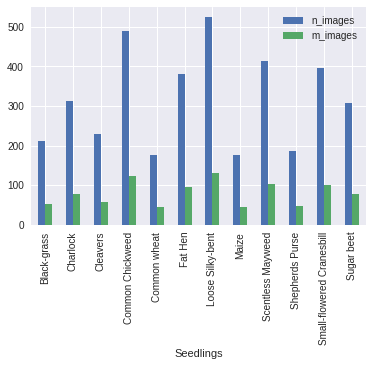

In [29]:
full_df.plot(kind="bar", grid=True)

In [0]:
## Investigate Image resolution distribution

In [0]:
#arch = vgg16
arch = resnet34
#arch = resnext50
#arch = resnext101_64
sz = 224
bs = 64

In [0]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))

In [33]:
#pick first image just for viewing
pic = PATH + data.trn_ds.fnames[0]; pic

'drive/My Drive/data/PlantSeedlings/train/Black-grass/e7d7e6351.png'

In [0]:
img = PIL.Image.open(pic); img

In [0]:
# create python data dictionary {}, path/file and image size(x,y)
# ps very long processing time
e_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}

In [0]:
e_d

In [0]:
row_sz, col_sz = list(zip(*e_d.values()))

In [120]:
row_sz[:5]

(740, 836, 772, 740, 766)

In [0]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [122]:
row_sz[:5]

array([740, 836, 772, 740, 766])

In [128]:
print(min(row_sz), max(row_sz))

49 3991


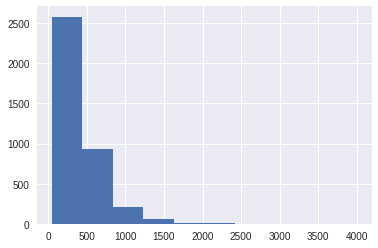

In [123]:
plt.hist(row_sz);

(array([126., 249., 338., 320., 399., 228.,  95., 100.,  63.,  84.]),
 array([ 49.,  74.,  99., 124., 149., 174., 199., 224., 249., 274., 299.]),
 <a list of 10 Patch objects>)

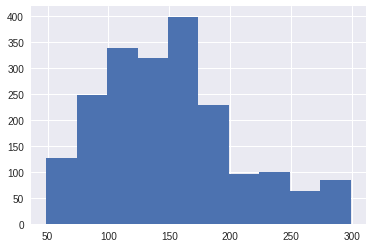

In [134]:
plt.hist(row_sz[row_sz < 300])

##Review: easy steps to train a world-class image classifier

 *   precompute=True
 *   Use lr_find() to find highest learning rate where loss is still clearly improving
 *   Train last layer from precomputed activations for 1-2 epochs
 *   Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
 *   Unfreeze all layers
 *   Set earlier layers to 3x-10x lower learning rate than next higher layer
 *   Use lr_find() again
 *   Train full network with cycle_mult=2 until over-fitting


## Initial Model

In [0]:
#def get_data(sz, bs): # sz: image size, bs: batch size
#    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
#    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
    
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
#    return data if sz > 200 else data.resize(180, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 180 first saves time

#Source:   
#    def resize(self, targ, new_path):
#        new_ds = []
#        dls = [self.trn_dl,self.val_dl,self.fix_dl,self.aug_dl]
#        if self.test_dl: dls += [self.test_dl, self.test_aug_dl]
#        else: dls += [None,None]
#        t = tqdm_notebook(dls)
#        for dl in t: new_ds.append(self.resized(dl, targ, new_path))
#        t.close()
#        return self.__class__(new_ds[0].path, new_ds, self.bs, self.num_workers, self.classes)
#File:      ~/fastai/courses/dl1/fastai/dataset.py

In [0]:
# Precompute
#data = get_data(sz, bs)

In [37]:
# Get initial predictions on pre-trained network, just training last layers
# model trained on ImageNet (1.2 million images and 1000 classes) as a starting point.
# resnet34 is a version of the model that won the 2015 ImageNet competition. 
# precompute shall speed up the process

# tfms transform takes sz parameter, so it resizes all images to set size before when they are return as data objects!!!!!
# !!! but this tfms resize function is not very efficient with resizeing big (e.g. 1000x1000) images to 64x64 and
# takes centre crop, or with data augmentgation - it takes random crop. But takes long time!!!
# !! more efficient method woudl be to use data.resize()
# data = get_data(sz)
# data = data.resize(int(sz*1.3), 'tmp')
# which means, that we will not use bigger images than set ()sz * 1.3)

data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), bs=bs)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 50047857.38it/s]


epoch      trn_loss   val_loss   accuracy   
    0      1.585988   0.901294   0.720169  
    1      1.099657   0.7206     0.786695  



[array([0.7206]), 0.7866948264579209]

In [0]:
data.val_y

### Choosing a learning rate
The *learning rate* determines how quickly or how slowly you want to update the *weights* (or *parameters*). Learning rate is one of the most difficult parameters to set, because it significantly affects model performance.

The method `learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

We first create a new learner, since we want to know how to set the learning rate for a new (untrained) model.

In [0]:
learn = ConvLearner.pretrained(arch, data)

In [41]:
lrf=learn.lr_find()

 95%|█████████▌| 57/60 [00:07<00:00,  5.57it/s, loss=26.7]


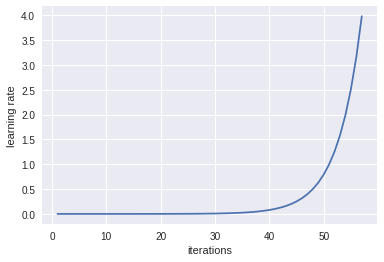

In [42]:
# Our learn object contains an attribute sched that contains our learning rate scheduler, and has some convenient plotting functionality including this one:
learn.sched.plot_lr()

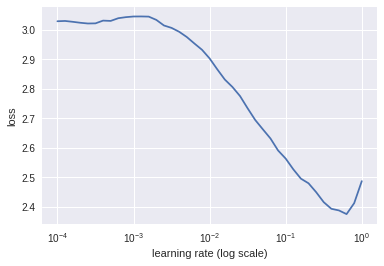

In [43]:
# plt.figure(figsize=(10,10))
#learn.sched.plot()
learn.sched.plot()


In [49]:
# selecting new learning rate for 5 epochs
learn.fit(0.1, 5)

epoch      trn_loss   val_loss   accuracy   
    0      0.738711   0.702608   0.796199  
    1      0.630407   0.587935   0.818374  
    2      0.610818   0.620447   0.806758  
    3      0.559557   0.529936   0.831045  
    4      0.530018   0.563834   0.826822  



[array([0.56383]), 0.8268215420253677]

In [0]:
learn.sched.plot_loss()

### Augment data set
If you try training for more epochs, you'll notice that we start to overfit, which means that our model is learning to recognize the specific images in the training set, rather than generalizing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through data augmentation. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

We can do this by passing aug_tfms (augmentation transforms) to tfms_from_model, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions transforms_side_on. We can also specify random zooming of images up to specified scale by adding the max_zoom parameter.


In [0]:
from sklearn import metrics

In [0]:
# alwyas disable precompute when using data augmentation to take effect

tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [0]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=4)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

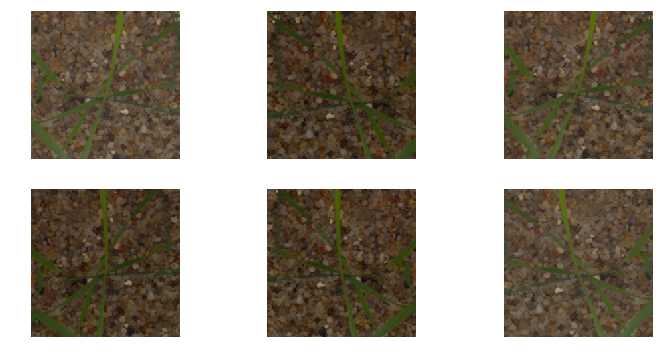

In [85]:
# plot augmented sample image
ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

In [0]:
# Let's create a new data object that includes this augmentation in the transforms, always disable precompute
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.precompute=False

In [87]:
%time learn.fit(0.1, 5)

epoch      trn_loss   val_loss   accuracy   
    0      1.570698   1.019979   0.704329  
    1      1.100212   0.621363   0.782471  
    2      0.833734   0.634545   0.788807  
    3      0.700743   0.549876   0.816262  
    4      0.592798   0.545085   0.821542  


[array([0.54508]), 0.8215417114205446]

In [0]:
learn.sched.plot_loss()

In [0]:
# By default when we create a learner, it sets all but the last layer to frozen. That means that it's still only updating the weights in the last layer when we call fit.
learn.precompute=False
% time learn.fit(1e-1, 3, cycle_len=1)

What is that cycle_len parameter? What we've done here is used a technique called stochastic gradient descent with restarts (SGDR), a variant of learning rate annealing, which gradually decreases the learning rate as training progresses. This is helpful because as we get closer to the optimal weights, we want to take smaller steps.

However, we may find ourselves in a part of the weight space that isn't very resilient - that is, small changes to the weights may result in big changes to the loss. We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate (this is the 'restarts' in 'SGDR'), which will force the model to jump to a different part of the weight space if the current area is "spikey". Here's a picture of how that might look if we reset the learning rates 3 times (in this paper they call it a "cyclic LR schedule"):

(From the paper [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)).

The number of epochs between resetting the learning rate is set by cycle_len, and the number of times this happens is refered to as the number of cycles, and is what we're actually passing as the 2nd parameter to fit(). So here's what our actual learning rates looked like:


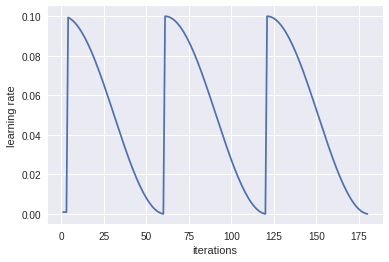

In [62]:
learn.sched.plot_lr()

In [0]:
# if Validation loss is much lower than training loss. This is a sign of underfitting. Cycle_len=1 may be too short. Let's set cycle_mult=2 to find better parameter.
# When you are under fitting, it means cycle_len=1 is too short (learning rate is getting reset before it had the chance to zoom in properly).

# in our case we are skipping this
# learn = ConvLearner.pretrained(arch, data)
# learn.fit(1e-1, 3, cycle_len=1, cycle_mult=2) # 1+2+4 = 7 epochs

In [0]:
learn.save('224_pre')

In [0]:
learn.load('224_pre')

###Fine-tuning and differential learning rate annealing
Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) unfreeze().


In [0]:
learn.unfreeze()
# keep batch normalization moving avg not be updated. Very important!!!
learn.ns_freeze(True)

ote that the other layers have already been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as differential learning rates, although there's no standard name for this techique in the literature that we're aware of.

In [66]:
lr=np.array([1e-3,1e-2,1e-1])
% time learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.544042   0.248311   0.916579  
    1      0.341448   0.271238   0.899683  
    2      0.208303   0.163796   0.941922  
    3      0.19588    0.251752   0.913411  
    4      0.152477   0.145457   0.955649  
    5      0.103658   0.13619    0.963041  
    6      0.075886   0.133565   0.966209  


[array([0.13357]), 0.9662090814352791]

In [0]:
learn.sched.plot_loss()

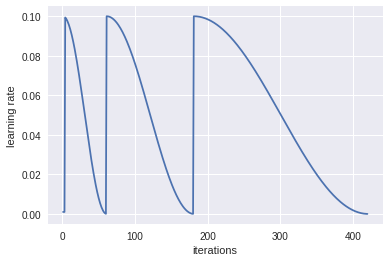

In [67]:
#Another trick we've used here is adding the cycle_mult parameter. Take a look at the following chart, and see if you can figure out what the parameter is doing:
learn.sched.plot_lr()

Note that's what being plotted above is the learning rate of the final layers. The learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested (i.e. the first layers have 100x smaller, and middle layers 10x smaller learning rates, since we set lr=np.array([1e-4,1e-3,1e-2]).

In [0]:
learn.save('224_all')

In [0]:
learn.load('224_all')

###Increase image size

In [0]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
    
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
    return data if sz > 300 else data.resize(340, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time

#Source:   
#    def resize(self, targ, new_path):
#        new_ds = []
#        dls = [self.trn_dl,self.val_dl,self.fix_dl,self.aug_dl]
#        if self.test_dl: dls += [self.test_dl, self.test_aug_dl]
#        else: dls += [None,None]
#        t = tqdm_notebook(dls)
#        for dl in t: new_ds.append(self.resized(dl, targ, new_path))
#        t.close()
#        return self.__class__(new_ds[0].path, new_ds, self.bs, self.num_workers, self.classes)
#File:      ~/fastai/courses/dl1/fastai/dataset.py

In [78]:
# Starting training on small images for a few epochs, then switching to bigger images, and continuing training is an amazingly effective way to avoid overfitting.

# http://forums.fast.ai/t/planet-classification-challenge/7824/96
# set_data doesn’t change the model at all. It just gives it new data to train with.
learn.set_data(get_data(299, bs)) 
learn.freeze()

#Source:   
#    def set_data(self, data, precompute=False):
#        super().set_data(data)
#        if precompute:
#            self.unfreeze()
#            self.save_fc1()
#            self.freeze()
#            self.precompute = True
#        else:
#            self.freeze()
#File:      ~/fastai/courses/dl1/fastai/conv_learner.py

In [0]:
# print model summary with layer description
learn.summary()

In [0]:
learn.fit(1e-1, 3, cycle_len=1)

In [0]:
learn.sched.plot_loss()

In [0]:
# frezzing all early layers, and training few more epochs on last layer
learn.freeze()


In [0]:
# after freezing, run one more set of training on last layer

In [92]:
# Validation loss is much lower than training loss. This is a sign of underfitting. Cycle_len=1 may be too short. Let's set cycle_mult=2 to find better parameter.
# When you are under fitting, it means cycle_len=1 is too short (learning rate is getting reset before it had the chance to zoom in properly).
learn.fit(1e-1, 3, cycle_len=1, cycle_mult=2) # 1+2+4 = 7 epochs

epoch      trn_loss   val_loss   accuracy   
    0      0.044033   0.141311   0.965153  
    1      0.039395   0.147917   0.964097  
    2      0.033292   0.14637    0.966209  
    3      0.033523   0.154026   0.960929  
    4      0.033044   0.149168   0.968321  
    5      0.03384    0.144893   0.969377  
    6      0.029884   0.145067   0.967265  


[array([0.14507]), 0.9672650477073009]

In [0]:
learn.sched.plot_loss()

In [0]:

# Test Time Augmentation for best predictions

In [93]:
log_preds, y = learn.TTA() # (5, 2044, 120), (2044,)
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9640971488912354, 0.1412811541262129)

In [0]:
learn.save('299_pre')

In [0]:
learn.load('299_pre')

## Analyzing Results
### Confusion matrix

In [0]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[ 41   0   0   0   0   0  11   0   0   0   0   0]
 [  0  76   0   0   0   2   0   0   0   0   0   0]
 [  0   0  57   0   0   0   0   0   0   0   0   0]
 [  0   0   0 121   0   0   0   0   1   0   0   0]
 [  3   0   0   0  41   0   0   0   0   0   0   0]
 [  1   0   0   0   0  94   0   0   0   0   0   0]
 [  4   0   0   0   0   0 126   0   0   0   0   0]
 [  0   0   0   0   1   0   0  42   1   0   0   0]
 [  0   0   0   0   0   0   1   0 102   0   0   0]
 [  0   0   0   2   0   0   0   0   4  40   0   0]
 [  0   0   0   0   0   0   1   0   0   0  98   0]
 [  0   0   0   1   0   0   1   0   0   0   0  75]]


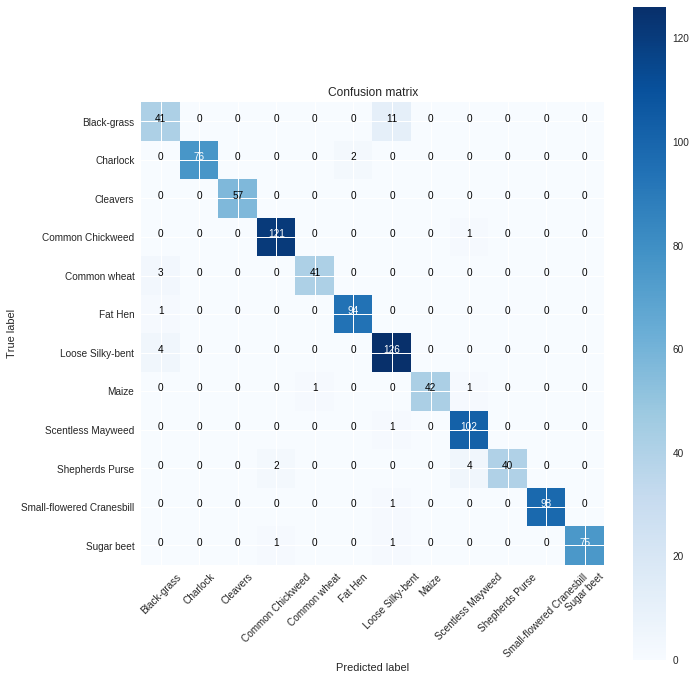

In [101]:
plot_confusion_matrix(cm, data.classes, figsize=(10,10))

## Analyzing results: looking at pictures

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (i.e. those with highest probability that are correct)
4. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
5. The most uncertain labels (i.e. those with probability closest to 0.5).

In [102]:
# This is the label for a val data
data.val_y

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3

In [103]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [104]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(947, 12)

In [105]:
log_preds[:10]

array([[ -0.00111, -17.11681, -17.92262, -15.74289, -12.13306, -14.66247,  -6.80844, -15.01985, -17.57133,
        -17.42664, -15.54914, -15.10686],
       [ -0.0073 , -17.35239, -17.07013, -15.67397, -10.69239, -15.58444,  -4.92754, -12.18884, -14.94134,
        -18.10676, -15.0844 , -13.24233],
       [ -0.51814, -11.57372,  -9.70149, -11.01508,  -6.21692,  -9.95782,  -0.911  ,  -9.33608, -11.98878,
        -13.46946, -11.28684, -11.00959],
       [ -0.78939, -16.54416, -14.11089, -14.66224, -12.82244, -15.43194,  -0.60539, -14.88358, -11.37543,
        -17.65348, -14.81901, -14.58668],
       [ -0.01781, -12.23984, -13.41535, -10.88984,  -4.87559,  -8.09014,  -4.65169,  -9.78623, -14.05313,
        -14.47913, -10.94836,  -9.61545],
       [ -0.04365, -11.55164, -12.05252, -13.41925,  -4.16717,  -8.04398,  -3.61773, -11.00206, -14.71635,
        -14.19757, -11.76531, -11.49719],
       [ -0.06104, -11.54605, -10.49151, -10.56359,  -6.85299,  -9.39352,  -2.84961,  -9.37815, -11.87537,

In [0]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [0]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [0]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [0]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

Correctly classified


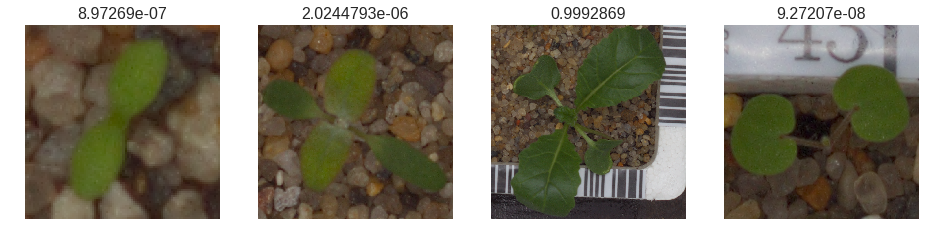

In [110]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


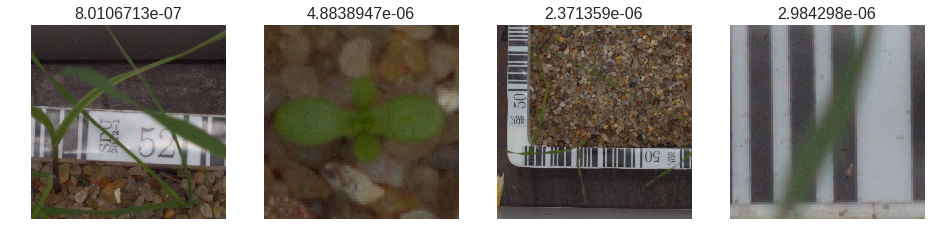

In [111]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [0]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [0]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

In [0]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

In [0]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

In [0]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

In [0]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Analyzing results: loss and accuracy

When we run `learn.fit` we print 3 performance values (see above.) Here 0.03 is the value of the **loss** in the training set, 0.0226 is the value of the loss in the validation set and 0.9927 is the validation accuracy. What is the loss? What is accuracy? Why not to just show accuracy?

**Accuracy** is the ratio of correct prediction to the total number of predictions.

In machine learning the **loss** function or cost function is representing the price paid for inaccuracy of predictions.

The loss associated with one example in binary classification is given by:
`-(y * log(p) + (1-y) * log (1-p))`
where `y` is the true label of `x` and `p` is the probability predicted by our model that the label is 1.

In [0]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))

In [0]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

Note that in our toy example above our accuracy is 100% and our loss is 0.16. Compare that to a loss of 0.03 that we are getting while predicting cats and dogs. Exercise: play with `preds` to get a lower loss for this example. 

**Example:** Here is an example on how to compute the loss for one example of binary classification problem. Suppose for an image x with label 1 and your model gives it a prediction of 0.9. For this case the loss should be small because our model is predicting a label $1$ with high probability.

`loss = -log(0.9) = 0.10`

Now suppose x has label 0 but our model is predicting 0.9. In this case our loss should be much larger.

loss = -log(1-0.9) = 2.30

- Exercise: look at the other cases and convince yourself that this make sense.
- Exercise: how would you rewrite `binary_loss` using `if` instead of `*` and `+`?

Why not just maximize accuracy? The binary classification loss is an easier function to optimize.